In [16]:
import sys
sys.path.insert(0, '../src/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import shap
import warnings
import sys
import pickle
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

import auto_co2 as co2

%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)
sys.path.insert(0, '../src/')


# file_path = "../data/processed/co2_classification_dataset_fr-de-2021.csv"
file_path = "../data/processed/co2_classification_20240116-234301.csv"

# Convert the loaded data to a DataFrame
df = pd.read_csv(file_path)

# **0. Introduction**


In [9]:
co2.styles.display_info(df)
target = df['Co2Grade']
data = df.drop(columns='Co2Grade')

co2.styles.displayer(data)
co2.styles.displayer(pd.DataFrame(target))

co2.viz.plot_distribution_pie(target, interactive=True, save=True, format='png')

,Column,Non-Null Count,Dtype
0,MassRunningOrder,2100 non-null,float64
1,BaseWheel,2100 non-null,float64
2,EnginePower,2100 non-null,float64
3,InnovativeTechnology,2100 non-null,int64
4,ElecRange_NO_RANGE,2100 non-null,int64
5,ElecRange_0to50,2100 non-null,int64
6,ElecRange_50to100,2100 non-null,int64
7,ElecRange_100to150,2100 non-null,int64
8,ElecRange_150+,2100 non-null,int64
9,Pool_BMW,2100 non-null,int64


<class 'pandas.io.formats.style.Styler'>


,Info
0,"RangeIndex: 2100 entries, 0 to 2099"
1,Data columns (total 29 columns):
2,28 Co2Grade 2100 non-null object
3,"dtypes: float64(3), int64(25), object(1)"
4,memory usage: 475.9+ KB


<class 'pandas.io.formats.style.Styler'>


,MassRunningOrder,BaseWheel,EnginePower,InnovativeTechnology,ElecRange_NO_RANGE,ElecRange_0to50,ElecRange_50to100,ElecRange_100to150,ElecRange_150+,Pool_BMW,Pool_FORD,Pool_HYUNDAI,Pool_KIA,Pool_MAZDA-SUBARU-SUZUKI-TOYOTA,Pool_MERCEDES-BENZ,Pool_RENAULT-NISSAN-MITSUBISHI,Pool_STELLANTIS,Pool_TESLA,Pool_VW-SAIC,FuelType_DIESEL,FuelType_DIESEL/ELECTRIC,FuelType_E85,FuelType_ELECTRIC,FuelType_LPG,FuelType_NG,FuelType_NG-BIOMETHANE,FuelType_PETROL,FuelType_PETROL/ELECTRIC
0,1615.000,2829.000,128.000,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
1,1313.000,2667.000,81.000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,1248.000,2417.000,61.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,1990.000,2822.000,245.000,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1825.000,2875.000,100.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0


<class 'pandas.io.formats.style.Styler'>


,Co2Grade
0,C
1,B
2,A
3,E
4,A


<class 'pandas.io.formats.style.Styler'>


In [10]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=.2, random_state=42)

# **1. Modèles simples**

## **A. Decision Tree**

In [18]:
%%time
dtc = DecisionTreeClassifier(criterion='gini', max_depth=20)
dtc.fit(X_train, y_train)
dtc_pred = dtc.predict(X_test)

co2.viz.plot_confusion_matrix(y_test, dtc_pred, classes=dtc.classes_, title=': Decision Tree', save=True, format='png')
co2.styles.display_classification_report(y_test, dtc_pred)

co2.data.save_model(dtc)

,precision,recall,f1-score,support
A,1.000,1.000,1.000,84.000
B,0.729,0.797,0.761,64.000
C,0.873,0.845,0.859,155.000
D,0.853,0.821,0.837,78.000
E,0.774,0.828,0.800,29.000
F,0.500,0.667,0.571,3.000
G,0.833,0.714,0.769,7.000
accuracy,0.860,0.860,0.860,0.860
macro avg,0.795,0.810,0.800,420.000
weighted avg,0.863,0.860,0.861,420.000


<class 'pandas.io.formats.style.Styler'>


AttributeError: module 'datetime' has no attribute 'now'

In [5]:
co2.styles.display_feature_importances(dtc, data)

,importance
EnginePower,0.242
MassRunningOrder,0.220
ElecRange_NO_RANGE,0.182
BaseWheel,0.130
FuelType_ELECTRIC,0.092
FuelType_PETROL,0.026
FuelType_PETROL/ELECTRIC,0.023
Pool_MAZDA-SUBARU-SUZUKI-TOYOTA,0.020
InnovativeTechnology,0.010
Pool_STELLANTIS,0.008


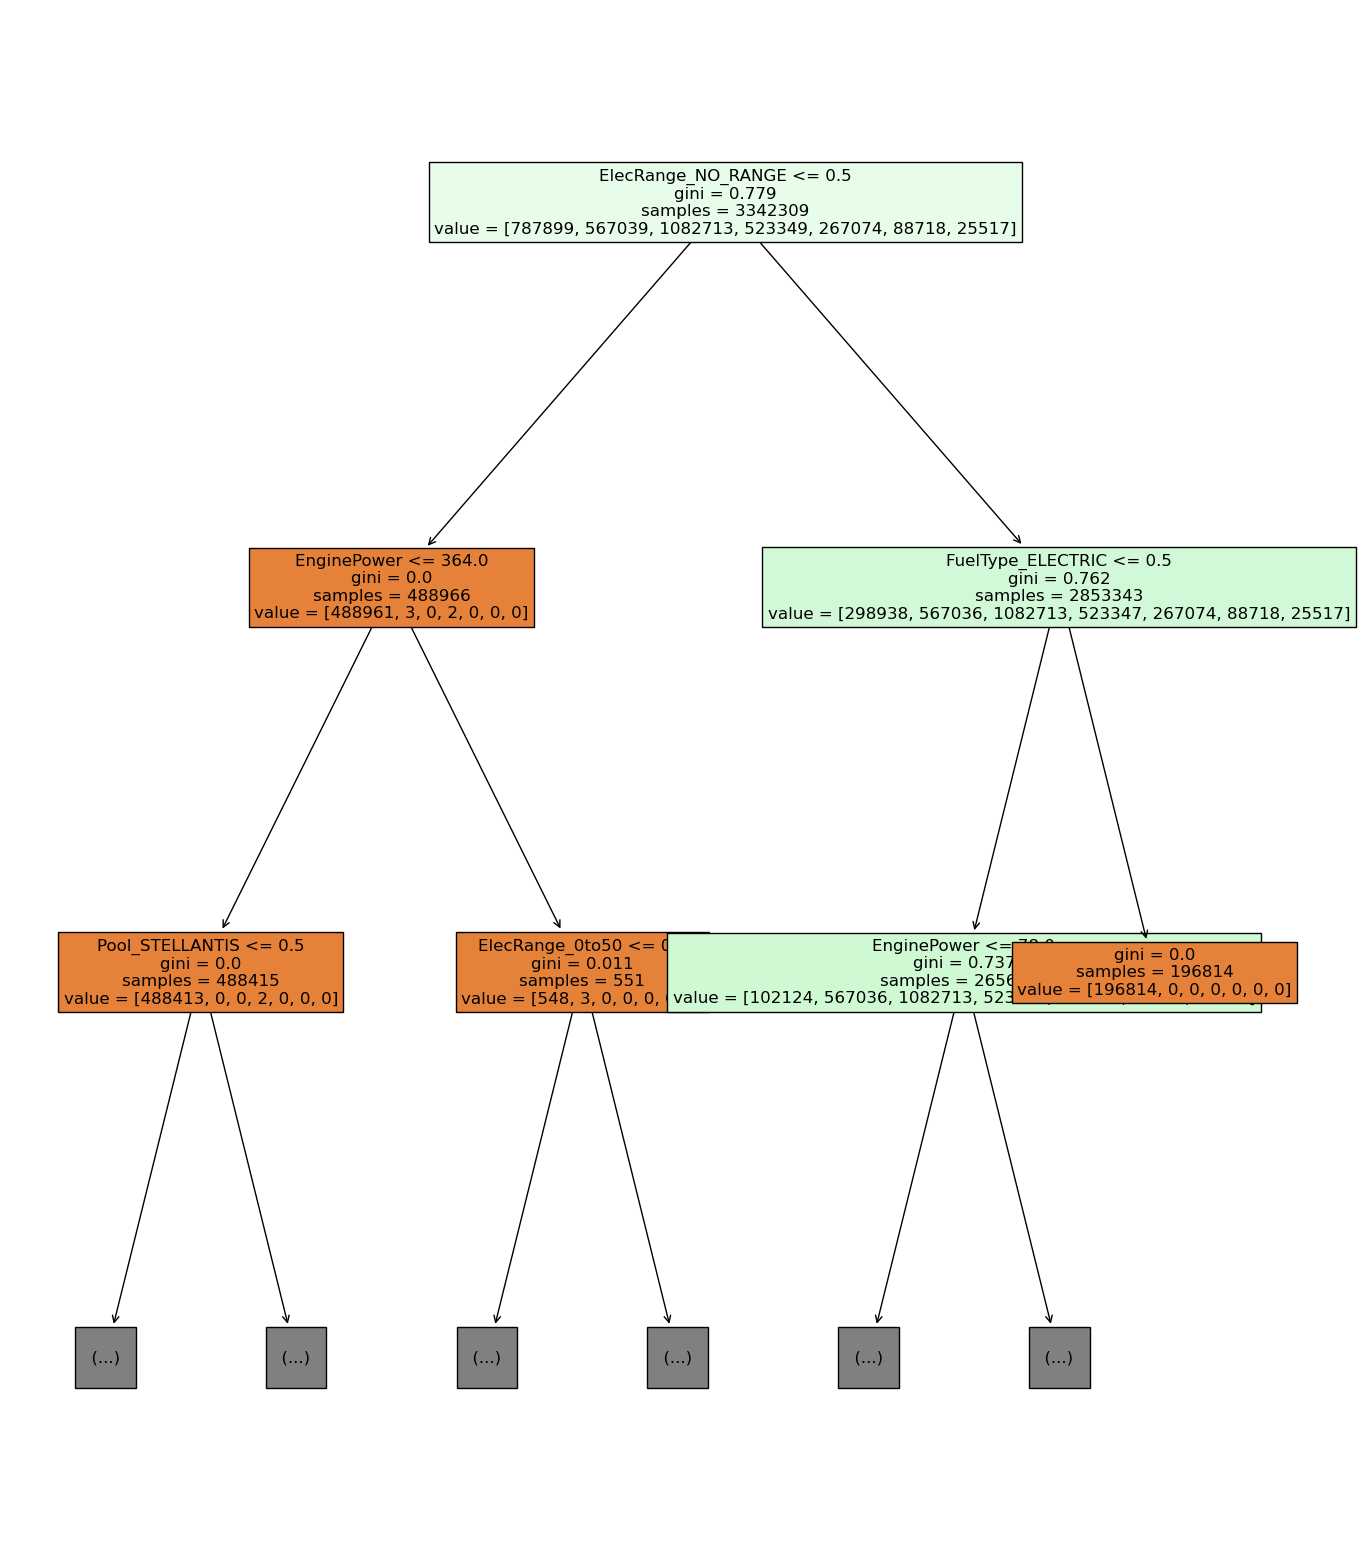

In [6]:
plt.figure(figsize=(16, 20))

plot_tree(dtc, feature_names=X_train.columns.tolist(),
          max_depth=2, filled=True, fontsize=12);

In [7]:
y_pred = dtc.predict_proba(X_test)
co2.viz.plot_roc_curves(y_test, y_pred, title='Decision Tree', interactive=True, save=True, format='png')

## **B. Random Forest**

In [8]:
%%time
rfc = RandomForestClassifier(n_estimators=200, criterion='entropy', n_jobs=-1, random_state=42)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

co2.viz.plot_confusion_matrix(y_test, rfc_pred, palette='Greens', classes=dtc.classes_, title=': Random Forest', save=True, format='png')
co2.styles.display_classification_report(y_test, rfc_pred)

co2.data.save_model(rfc)

,precision,recall,f1-score,support
A,1.000,0.999,1.000,197120.000
B,0.913,0.950,0.931,141817.000
C,0.940,0.929,0.935,270657.000
D,0.924,0.913,0.918,130460.000
E,0.954,0.935,0.944,66734.000
F,0.949,0.965,0.957,22507.000
G,0.974,0.960,0.967,6283.000
accuracy,0.948,0.948,0.948,0.948
macro avg,0.950,0.950,0.950,835578.000
weighted avg,0.949,0.948,0.948,835578.000


Model saved at ../models/RandomForestClassifier_20240114_013210.pkl
CPU times: user 23min 11s, sys: 6.7 s, total: 23min 18s
Wall time: 1min 47s


In [9]:
co2.styles.display_feature_importances(rfc, data)

,importance
MassRunningOrder,0.286
EnginePower,0.192
BaseWheel,0.144
FuelType_ELECTRIC,0.063
ElecRange_NO_RANGE,0.061
FuelType_PETROL,0.047
FuelType_DIESEL,0.042
InnovativeTechnology,0.037
FuelType_PETROL/ELECTRIC,0.031
Pool_MAZDA-SUBARU-SUZUKI-TOYOTA,0.015


## **2. Réduction de dimensions**

In [10]:
pca = PCA(n_components=None)
data_pca = pca.fit_transform(data)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(data_pca, target, test_size=.2, random_state=42)

In [11]:
co2.viz.plot_pca_variance(pca, n_features=5, save=True, format='png')

# **3. Modèle d'ensemble: XGBoost**

In [12]:
encoder = LabelEncoder()
target_enc = encoder.fit_transform(target)

X_x, X_valid_x, y_x, y_valid_x = train_test_split(data, target_enc, test_size=.1)
X_train_x, X_test_x, y_train_x, y_test_x = train_test_split(X_x, y_x, test_size=.2, random_state=42)

In [13]:
%%time

xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                            n_estimators=600, #400
                            num_class=7, 
                            early_stopping_rounds=20, 
                            eval_metric=['merror','mlogloss'], 
                            seed=42,
                            n_jobs=-1,
                            verbosity=2)
xgb_clf.fit(X_train_x, y_train_x, eval_set=[(X_train_x, y_train_x), (X_test_x, y_test_x)])

[0]	validation_0-merror:0.16115	validation_0-mlogloss:1.30995	validation_1-merror:0.16179	validation_1-mlogloss:1.31031
[1]	validation_0-merror:0.14817	validation_0-mlogloss:1.04580	validation_1-merror:0.14846	validation_1-mlogloss:1.04612
[2]	validation_0-merror:0.14261	validation_0-mlogloss:0.87630	validation_1-merror:0.14269	validation_1-mlogloss:0.87659
[3]	validation_0-merror:0.14345	validation_0-mlogloss:0.76220	validation_1-merror:0.14356	validation_1-mlogloss:0.76248
[4]	validation_0-merror:0.13580	validation_0-mlogloss:0.66736	validation_1-merror:0.13620	validation_1-mlogloss:0.66767
[5]	validation_0-merror:0.13692	validation_0-mlogloss:0.59450	validation_1-merror:0.13724	validation_1-mlogloss:0.59494
[6]	validation_0-merror:0.12789	validation_0-mlogloss:0.54314	validation_1-merror:0.12833	validation_1-mlogloss:0.54353
[7]	validation_0-merror:0.12424	validation_0-mlogloss:0.49690	validation_1-merror:0.12450	validation_1-mlogloss:0.49734
[8]	validation_0-merror:0.11907	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=600,
              n_jobs=-1, num_class=7, num_parallel_tree=None, ...)

In [14]:
co2.viz.plot_xgboost(results=xgb_clf.evals_result_, metric='merror', title=' Classifier: Erreur Moyenne')
co2.viz.plot_xgboost(results=xgb_clf.evals_result_, metric='mlogloss', title='Classifier: Moyenne LogLoss')

In [15]:
xgb_pred = xgb_clf.predict(X_test_x)

co2.viz.plot_confusion_matrix(y_test_x, xgb_pred, classes=xgb_clf.classes_, palette='Reds', 
                              title=': XGBoost Classifier', save=True, format='png')
co2.styles.display_classification_report(y_test_x, xgb_pred)

co2.data.save_model(xgb_clf, model_type='xgb')

,precision,recall,f1-score,support
0,1.000,0.999,0.999,177470.000
1,0.915,0.943,0.929,128048.000
2,0.936,0.929,0.933,243379.000
3,0.919,0.910,0.915,117248.000
4,0.949,0.933,0.941,60244.000
5,0.942,0.963,0.953,19974.000
6,0.989,0.949,0.969,5657.000
accuracy,0.946,0.946,0.946,0.946
macro avg,0.950,0.947,0.948,752020.000
weighted avg,0.947,0.946,0.946,752020.000


Model saved at ../models/XGBClassifier_20240114_013725.model


/home/mln/miniconda3/envs/co2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning:

[01:37:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076482591/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



<Axes: >

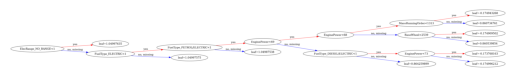

In [16]:
from xgboost import plot_tree
plot_tree(xgb_clf, num_trees=0, rankdir='LR')


In [17]:
co2.viz.plot_feature_importance(xgb_clf, title=': XGBoost Classifier', save=True, format='png')

In [18]:
xgb_valid_pred = xgb_clf.predict(X_valid_x)
co2.viz.plot_confusion_matrix(y_valid_x, xgb_valid_pred, classes=xgb_clf.classes_, palette='Reds',
                              title=': XGBoost Classifier')
co2.styles.display_classification_report(y_valid_x, xgb_valid_pred) 


,precision,recall,f1-score,support
0,1.000,0.999,1.000,98280.000
1,0.915,0.944,0.929,70560.000
2,0.937,0.930,0.933,135727.000
3,0.921,0.911,0.916,65625.000
4,0.950,0.935,0.942,33338.000
5,0.943,0.964,0.954,11037.000
6,0.989,0.942,0.965,3222.000
accuracy,0.947,0.947,0.947,0.947
macro avg,0.951,0.946,0.948,417789.000
weighted avg,0.947,0.947,0.947,417789.000


# **3. Interprétabilité des modèles**

In [19]:
%%time
shap_sample = X_test_x.sample(frac=0.1, random_state=42)
explainer = shap.Explainer(xgb_clf.predict, shap_sample)
# Calculates the SHAP values - It takes some time
shap_values = explainer(shap_sample)
co2.data.save_shap_values(shap_values, shap_sample)

PermutationExplainer explainer: 75203it [2:28:09,  8.45it/s]                             


SHAP values saved at ../output/interpretability/Explanation_shap_values_20240114_040539.csv
Explainer information saved at ../output/interpretability/Explanation_explainer_20240114_040539.csv
CPU times: user 1d 13h 53min 28s, sys: 2min 1s, total: 1d 13h 55min 30s
Wall time: 2h 34min 10s


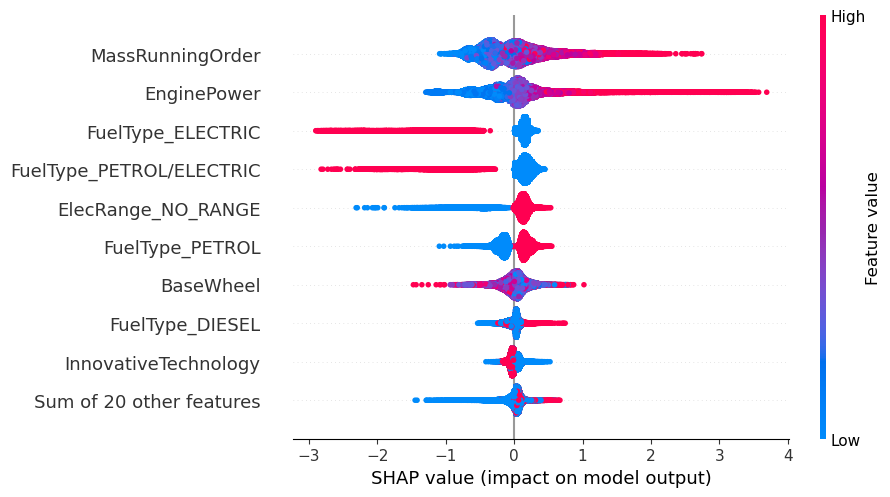

In [20]:
shap.plots.beeswarm(shap_values)

In [21]:
shap.initjs()
shap.plots.force(shap_values[0:300])


In [22]:
#shap.summary_plot(shap_values, X_test_x, plot_type='bar', feature_names=X_test_x.columns)
co2.viz.plot_shap_summary(shap_values, feature_names=X_test_x.columns, title=': XGBoost Classifier', save=True, format='png')

In [23]:
import lime
from lime import lime_tabular

# Create a Lime explainer object
explainer = lime_tabular.LimeTabularExplainer(training_data=X_train_x.to_numpy(), 
                                              feature_names=X_train_x.columns, 
                                              class_names=['0', '1'], 
                                              mode='classification')

# Choose a random instance for which to explain the model's prediction
i = np.random.randint(0, X_test_x.shape[0])

# Get the explanation for the prediction
exp = explainer.explain_instance(X_test_x.iloc[i].to_numpy(), xgb_clf.predict_proba)

# Show the explanation
exp.show_in_notebook(show_table=True, show_all=False)